How to run the code: import PySpark first and load the data. Running 'Data Overview' Part is not necessary as its goal is just to allow the user to see how the data is.
'Compare Data' has to be run because it is used both for displaying discriminative variables but most importantly to build the DataFrame.
Once it is done, 'Gradient Boosted Trees' builds the model (average of 55 seconds of building time).
'Transform data set' imports the testset we have to use (do change if need be). Finally, run 'Save Prediction CSV' saves in the folder the CSV (By default, the name is 'Predictions0.csv').

# Import PySpark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
#!conda install -c conda-forge pyspark=2.4.4
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

import numpy as np

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

# Load Data **(Change path of data files depending on your workspace)**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load data from file.
import matplotlib.pyplot as plt
file_p = "/content/drive/MyDrive/ColabNotebooks/Project/exp1-train-400pos.bin" # TODO: Change path according to your workspace.
file_n = "/content/drive/MyDrive/ColabNotebooks/Project/exp1-train-2000neg.bin"
file_p2 = "/content/drive/MyDrive/ColabNotebooks/Project/exp2-train-400pos.bin"
file_n2 = "/content/drive/MyDrive/ColabNotebooks/Project/exp2-train-2000neg.bin"

tdp1 = np.fromfile(file_p, dtype=np.float32).reshape([400, 5, 768]) # Positive instances of first batch.
tdn1 = np.fromfile(file_n, dtype=np.float32).reshape([2000, 5, 768]) # Negative instances of first batch.
tdp2 = np.fromfile(file_p2, dtype=np.float32).reshape([400, 5, 768]) # Positive instances of second batch.
tdn2 = np.fromfile(file_n2, dtype=np.float32).reshape([2000, 5, 768]) # Negative instances of second batch.

# Data Overview

mean of positive spikes 1 :82.71910095214844
mean of positive spikes 2 :34.134647369384766
mean of negative spikes 1 :38.44295120239258
mean of negative spikes 2 :13.063738822937012
3840


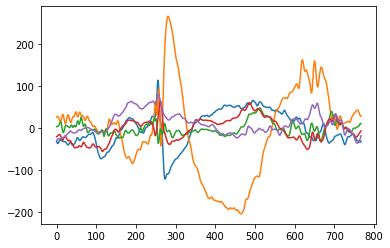

In [ ]:
# output data examples
import random
print(f"mean of positive spikes 1 :{np.mean(np.absolute(tdp1))}")
print(f"mean of positive spikes 2 :{np.mean(np.absolute(tdp2))}")
print(f"mean of negative spikes 1 :{np.mean(np.absolute(tdn1))}")
print(f"mean of negative spikes 2 :{np.mean(np.absolute(tdn2))}")

y = random.choice(tdp2)
print(y.size)
x = np.arange(0, 768)
for value in y :
  plt.plot(x,value)

In [ ]:
def get_nbr_intersection(sequence):
  j = 0
  nbr_intersection = 0
  val = []
  order = [0, 1, 2, 3, 4]
  for i in sequence:
    j+= 0.0005
    val.append(j+ (np.array(i) / np.array(i).sum()) / np.array(i).max())
  for o in range(768):
    values = [val[v][o] for v in order]
    new_values = sorted(values)
    if not(values == new_values):
      new_order = []
      for j in range(5):
        if not(values[j] == new_values[j]):
          nbr_intersection += 1
      for j in range(5):
        index_min = np.argmin(values)
        new_order.append(index_min)
        values[index_min] = 1000
      order = new_order
  return nbr_intersection

def get_normalized_sequence(sequence, j):
  return j + normalize_sequence(sequence)

def normalize_sequence(sequence):
    return (np.array(sequence) / np.array(sequence).sum()) / np.array(sequence).max()



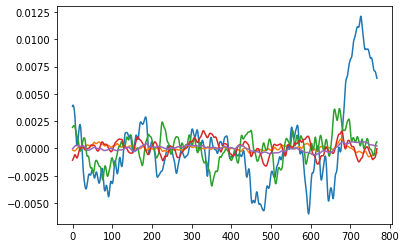

In [ ]:
sub = random.choice(tdn2)
addit = 0.0005

j=0
for i in sub:
  j+= addit
  plt.plot(x, normalize_sequence(i))


# Compare Data

## MEANs

800
4000


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


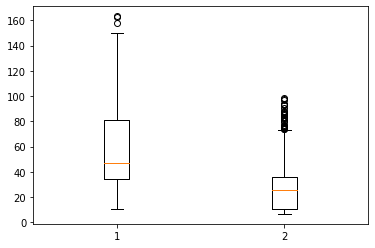

In [ ]:
mean_neg = []
mean_pos = []
for i in tdn1: 
  mean_neg.append(np.mean(np.absolute(i)))
for i in tdp1:
  mean_pos.append(np.mean(np.absolute(i)))

for i in tdn2:
  mean_neg.append(np.mean(np.absolute(i)))
for i in tdp2:
  mean_pos.append(np.mean(np.absolute(i)))
plt.boxplot([mean_pos, mean_neg])
print(len(mean_pos))
print(len(mean_neg))

In [ ]:
n_mean1 = []
n_mean2 = []
n_mean3 = []
n_mean4 = []
n_mean5 = []
for d in [tdn1, tdn2]:
  for s in d: 
    n_mean1.append(np.mean(np.absolute(s[0])))
    n_mean2.append(np.mean(np.absolute(s[1])))
    n_mean3.append(np.mean(np.absolute(s[2])))
    n_mean4.append(np.mean(np.absolute(s[3])))
    n_mean5.append(np.mean(np.absolute(s[4])))

In [ ]:
p_mean1 = []
p_mean2 = []
p_mean3 = []
p_mean4 = []
p_mean5 = []
for d in [tdp1, tdp2]:
  for s in d: 
    p_mean1.append(np.mean(np.absolute(s[0])))
    p_mean2.append(np.mean(np.absolute(s[1])))
    p_mean3.append(np.mean(np.absolute(s[2])))
    p_mean4.append(np.mean(np.absolute(s[3])))
    p_mean5.append(np.mean(np.absolute(s[4])))

4000
800


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


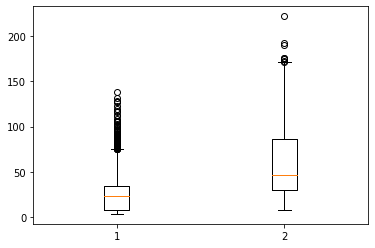

In [ ]:
plt.boxplot([n_mean1, p_mean1]) #1
print(len(n_mean1))
print(len(p_mean1))

25.753344
58.426884


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


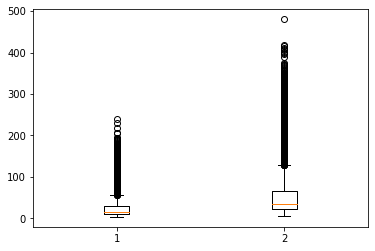

In [ ]:
test_n = n_mean1 * 1 + n_mean2 * 1 + n_mean3 * 1 + n_mean4 * 1 + n_mean5 * 1 
test_p = p_mean1 * 1 + p_mean2 * 1 + p_mean3 * 1 + p_mean4 * 1 + p_mean5 * 1
plt.boxplot([test_n, test_p])
print(np.mean(test_n))
print(np.mean(test_p))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


4000


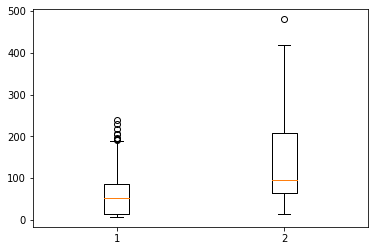

In [ ]:
plt.boxplot([n_mean2, p_mean2])
print(len(n_mean2))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


4000


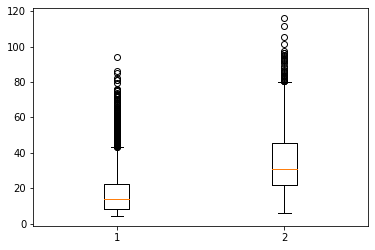

In [ ]:
plt.boxplot([n_mean3, p_mean3])
print(len(n_mean3))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


4000


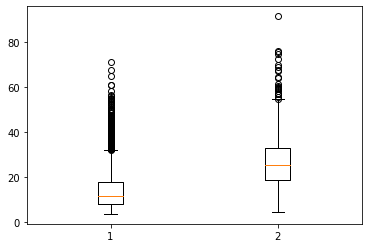

In [ ]:
plt.boxplot([n_mean4, p_mean4])
print(len(n_mean4))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


4000


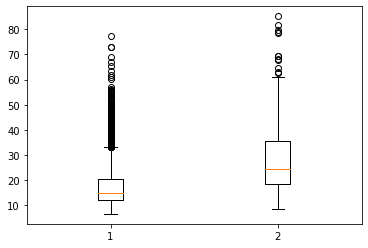

In [ ]:
plt.boxplot([n_mean5, p_mean5])
print(len(n_mean5))

## VALUES

In [ ]:
n_minv = [[], [], [], [], []]
n_maxv = [[], [], [], [], []]
for d in [tdn1, tdn2]:
  for i in d:
    n_minv[0].append(min(i[0]))
    n_minv[1].append(min(i[1]))
    n_minv[2].append(min(i[2]))
    n_minv[3].append(min(i[3]))
    n_minv[4].append(min(i[4]))
    n_maxv[0].append(max(i[0]))
    n_maxv[1].append(max(i[1]))
    n_maxv[2].append(max(i[2]))
    n_maxv[3].append(max(i[3]))
    n_maxv[4].append(max(i[4]))

In [ ]:
p_minv = [[], [], [], [], []]
p_maxv = [[], [], [], [], []]
for d in [tdp1, tdp2]:
  for i in d:
    p_minv[0].append(min(i[0]))
    p_minv[1].append(min(i[1]))
    p_minv[2].append(min(i[2]))
    p_minv[3].append(min(i[3]))
    p_minv[4].append(min(i[4]))
    p_maxv[0].append(max(i[0]))
    p_maxv[1].append(max(i[1]))
    p_maxv[2].append(max(i[2]))
    p_maxv[3].append(max(i[3]))
    p_maxv[4].append(max(i[4]))

541.6478
1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'boxes': [<matplotlib.lines.Line2D at 0x7f094776f550>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0947775550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f094777b590>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f094777b050>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f094776fa90>,
  <matplotlib.lines.Line2D at 0x7f0947703590>]}

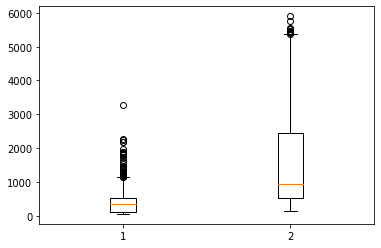

In [ ]:
def min_max(minv, maxv, i):
  t_minv = np.absolute(min(minv[0][i], minv[1][i], minv[2][i], minv[3][i], minv[4][i]))
  t_maxv = np.absolute(max(maxv[0][i], maxv[1][i], maxv[2][i], maxv[3][i], maxv[4][i]))
  return t_minv + t_maxv

print(min_max(n_minv, n_maxv, 6))
n_mm = []
p_mm = []
for i in range(4000):
  n_mm.append(min_max(n_minv, n_maxv, i))
for i in range(800):
  p_mm.append(min_max(p_minv, p_maxv, i))
print(1)
plt.boxplot([n_mm, p_mm])

### MIN

1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


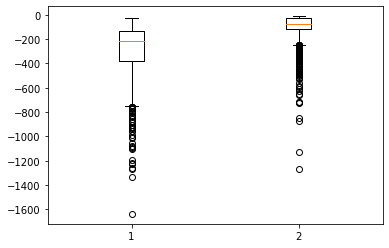

In [ ]:
plt.boxplot([p_minv[0], n_minv[0]])
print(1)

1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


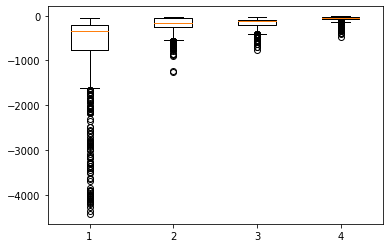

In [ ]:
plt.boxplot([p_minv[1], n_minv[1],p_minv[2], n_minv[2]])
print(1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


1


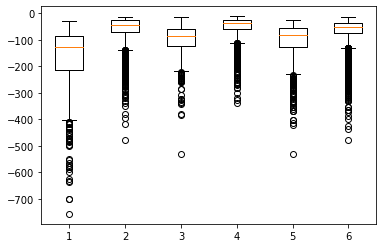

In [ ]:
plt.boxplot([p_minv[2], n_minv[2],p_minv[3], n_minv[3],p_minv[4], n_minv[4]])
print(1)

### MAX


1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


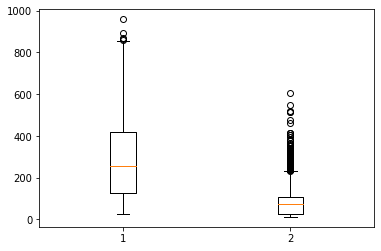

In [ ]:
plt.boxplot([p_maxv[0], n_maxv[0]])
print(1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


1


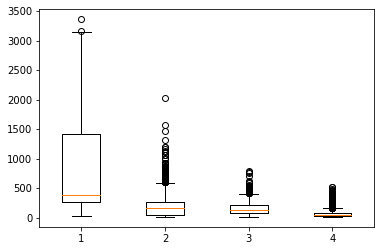

In [ ]:
plt.boxplot([p_maxv[1], n_maxv[1],p_maxv[2], n_maxv[2]])
print(1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


1


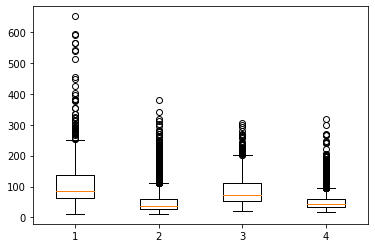

In [ ]:
plt.boxplot([p_maxv[3], n_maxv[3],p_maxv[4], n_maxv[4]])
print(1)

## SIGNAL MOVEMENT

In [ ]:
def get_difference(sequence, step):
  sv = [[], [], [], [], []]
  for i, s in enumerate(sequence):
    sv[i].append(s[0])
    for j in range(step, 767,step):
      sv[i].append(np.abs(s[j] - s[j-step]))
  return sv

1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


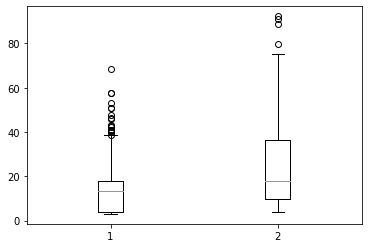

In [ ]:
sgm_n = []
sgm_p = []
for d in [tdn1, tdn2]:
  for s in d:
    sgm_n.append(np.mean(get_difference(s, 5)[0]))
for d in [tdp1, tdp2]:
  for s in d:
    sgm_p.append(np.mean(get_difference(s, 5)[0]))

plt.boxplot([sgm_n, sgm_p])
print(1)

### individual signal

In [ ]:
n_diff = [[], [], [], [], []]
p_diff = [[], [], [], [], []]
for d in [tdp1, tdp2]:
  for i in d:
    dc = get_difference(i, 5)
    p_diff[0].append(np.mean(dc[0]))
    p_diff[1].append(np.mean(dc[1]))
    p_diff[2].append(np.mean(dc[2]))
    p_diff[3].append(np.mean(dc[3]))
    p_diff[4].append(np.mean(dc[4]))
for d in [tdn1, tdn2]:
  for i in d:
    dc = get_difference(i, 5)
    n_diff[0].append(np.mean(dc[0]))
    n_diff[1].append(np.mean(dc[1]))
    n_diff[2].append(np.mean(dc[2]))
    n_diff[3].append(np.mean(dc[3]))
    n_diff[4].append(np.mean(dc[4]))

1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


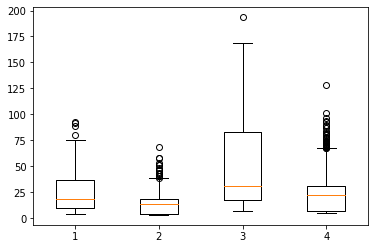

In [ ]:
plt.boxplot([p_diff[0], n_diff[0],p_diff[1], n_diff[1]])
print(1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


1


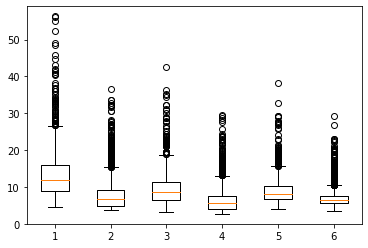

In [ ]:
plt.boxplot([p_diff[2], n_diff[2],p_diff[3], n_diff[3], p_diff[4], n_diff[4]])
print(1)

### MAX OF INDIVIDUAL SIGNAL (INSTEAD OF THE MEAN)

In [ ]:
n_dm = [[], [], [], [], []]
p_dm = [[], [], [], [], []]
for d in [tdp1, tdp2]:
  for i in d:
    dc = get_difference(i, 5)
    p_dm[0].append(max(dc[0]))
    p_dm[1].append(max(dc[1]))
    p_dm[2].append(max(dc[2]))
    p_dm[3].append(max(dc[3]))
    p_dm[4].append(max(dc[4]))
for d in [tdn1, tdn2]:
  for i in d:
    dc = get_difference(i, 5)
    n_dm[0].append(max(dc[0]))
    n_dm[1].append(max(dc[1]))
    n_dm[2].append(max(dc[2]))
    n_dm[3].append(max(dc[3]))
    n_dm[4].append(max(dc[4]))

1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


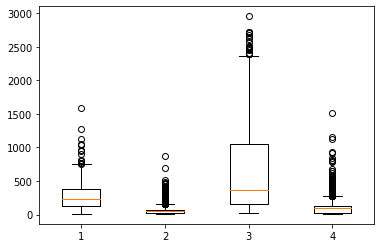

In [ ]:
plt.boxplot([p_dm[0], n_dm[0],p_dm[1], n_dm[1]])
print(1)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


1


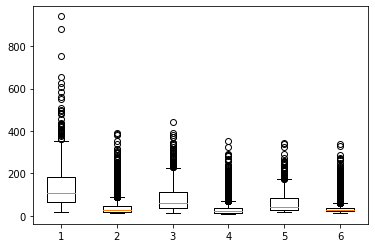

In [ ]:
plt.boxplot([p_dm[2], n_dm[2],p_dm[3], n_dm[3], p_dm[4], n_dm[4]])
print(1)

## DISTANCE

In [ ]:
def get_distance(sequence):
  dist = []
  for i in range(len(sequence[0])):
    min_s = min(sequence[0][i], sequence[1][i], sequence[2][i],sequence[3][i], sequence[4][i])
    max_s = max(sequence[0][i], sequence[1][i], sequence[2][i],sequence[3][i], sequence[4][i])
    dist.append(max_s - min_s)
  return np.mean(dist)

In [ ]:
p_dist = []
n_dist = []
for d in [tdp1, tdp2]:
  for i in d:
    p_dist.append(get_distance(i))
for d in [tdn1, tdn2]:
  for i in d:
    n_dist.append(get_distance(i))

1


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


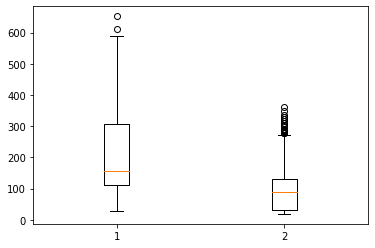

In [ ]:
plt.boxplot([p_dist, n_dist])
print(1)

## WAVELET TRANSFORM

In [ ]:
import pywt # 1 & 10
(cA_n1, cD_n1) = pywt.dwt(tdn1, 'db1')
(cA_p1, cD_p1) = pywt.dwt(tdp1, 'db1')
(cA_n2, cD_n2) = pywt.dwt(tdn2, 'db1')
(cA_p2, cD_p2) = pywt.dwt(tdp2, 'db1')
r_wlt = np.mean(cA_p1[0],axis = 1)
# print (r_wlt)

In [ ]:
cap = [[], [], [], [], []]
can = [[], [], [], [], []]

for i in [cA_p1, cA_p2]:
  for j in range(400):
    ca = np.mean(np.absolute(i[j]), axis = 1)
    for x in range(len(cap)):
      cap[x].append(ca[x])
for i in [cA_n1, cA_n2]:
  for p in range(2000):
    ca = np.mean(np.absolute(i[p]),axis = 1)
    for x in range(len(can)):
      can[x].append(ca[x])

a


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


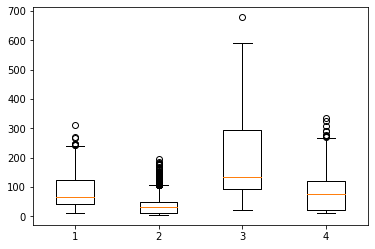

In [ ]:
plt.boxplot([cap[0], can[0], cap[1], can[1]])
print("a")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


a


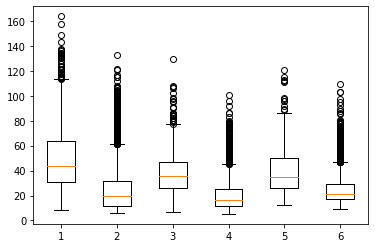

In [ ]:
plt.boxplot([cap[2], can[2], cap[3], can[3], cap[4], can[4]])
print("a")

In [ ]:
cdp = [[], [], [], [], []]
cdn = [[], [], [], [], []]

for i in [cD_p1, cD_p2]:
  for j in range(400):
    cd = np.mean(np.absolute(i[j]), axis = 1)
    for x in range(len(cdp)):
      cdp[x].append(cd[x])
for i in [cD_n1, cD_n2]:
  for p in range(2000):
    cd = np.mean(np.absolute(i[p]),axis = 1)
    for x in range(len(cdn)):
      cdn[x].append(cd[x])

a


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


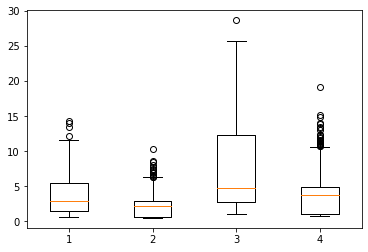

In [ ]:
plt.boxplot([cdp[0], cdn[0], cdp[1], cdn[1]])
print("a")

a


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


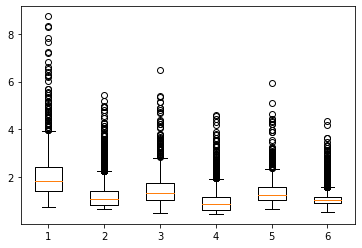

In [ ]:
plt.boxplot([ cdp[2], cdn[2], cdp[3], cdn[3], cdp[4], cdn[4]])
print("a")

In [ ]:
(cA_n1, cD_n1) = pywt.dwt(tdn1, 'db10')
(cA_p1, cD_p1) = pywt.dwt(tdp1, 'db10')
(cA_n2, cD_n2) = pywt.dwt(tdn2, 'db10')
(cA_p2, cD_p2) = pywt.dwt(tdp2, 'db10')
cap2 = [[], [], [], [], []]
can2 = [[], [], [], [], []]

for i in [cA_p1, cA_p2]:
  for j in range(400):
    ca = np.mean(np.absolute(i[j]), axis = 1)
    for x in range(len(cap)):
      cap2[x].append(ca[x])
for i in [cA_n1, cA_n2]:
  for p in range(2000):
    ca = np.mean(np.absolute(i[p]),axis = 1)
    for x in range(len(can)):
      can2[x].append(ca[x])

cdp2 = [[], [], [], [], []]
cdn2 = [[], [], [], [], []]

for i in [cD_p1, cD_p2]:
  for j in range(400):
    cd = np.mean(np.absolute(i[j]), axis = 1)
    for x in range(len(cdp)):
      cdp2[x].append(cd[x])
for i in [cD_n1, cD_n2]:
  for p in range(2000):
    cd = np.mean(np.absolute(i[p]),axis = 1)
    for x in range(len(cdn)):
      cdn2[x].append(cd[x])

## INTERSECTION

In [ ]:
p_i = []
n_i = []
for d in [tdp1, tdp2]:
  for i in d:
    p_i.append(get_nbr_intersection(i))
for d in [tdn1, tdn2]:
  for j in d:
    n_i.append(get_nbr_intersection(j))

print(p_i)
print(n_i)
print(np.mean(n_i))
print(np.mean(n_i))

[2682, 1202, 1421, 2485, 3108, 2903, 3146, 3172, 2881, 1210, 958, 2092, 1796, 1270, 1721, 2814, 2269, 2372, 2445, 2165, 2863, 2018, 2708, 2599, 2226, 2714, 1738, 1840, 2700, 0, 1778, 2702, 1618, 2079, 2, 1764, 2992, 2809, 2765, 3107, 1166, 1359, 2651, 2963, 2266, 1996, 3164, 2959, 1128, 2959, 2932, 2710, 2837, 1026, 2619, 2647, 1814, 3166, 2857, 2247, 2581, 2525, 2900, 2550, 2527, 2848, 2004, 2691, 2274, 2832, 3086, 2297, 2929, 2851, 194, 2415, 1060, 2157, 1892, 2814, 2153, 1123, 2870, 3236, 2922, 3101, 3291, 3039, 2301, 1850, 918, 1879, 1901, 962, 1300, 1291, 490, 2728, 2873, 2728, 1827, 2335, 2261, 3112, 1851, 2504, 2490, 2204, 0, 1994, 1056, 3146, 2295, 2388, 1795, 2826, 3194, 3029, 0, 2377, 1990, 972, 180, 1017, 2829, 2795, 2537, 1615, 1594, 1809, 2861, 2498, 2550, 1721, 3206, 2167, 2022, 922, 1876, 898, 831, 2848, 2655, 2980, 1016, 2098, 2539, 3087, 3034, 2448, 462, 2792, 2899, 2807, 2190, 2452, 1404, 3087, 2832, 3032, 1286, 2962, 1074, 2456, 2342, 1479, 1237, 2556, 954, 2871, 152

# DataFrame


In [ ]:
from pyspark.sql.types import *
columns = ["mean", "min", "max", "mxsig", "dist", "ca1", "ca2", "ca3", "ca4","ca5", "cd1","cd2", "cd3", "cd4", "cd5", "ca12", "ca22", "ca32", "ca42","ca52", "cd12","cd22", "cd32", "cd42", "cd52", "minmax","label"]
schema = StructType([
                     StructField("mean", DoubleType(), True),
                     StructField("min", DoubleType(), True),
                     StructField("max", DoubleType(), True),
                     StructField("mxsig", DoubleType(), True),
                     StructField("dist", DoubleType(), True),
                     StructField("cal", DoubleType(), True),
                     StructField("ca2", DoubleType(), True),
                     StructField("ca3", DoubleType(), True),
                     StructField("ca4", DoubleType(), True),
                     StructField("ca5", DoubleType(), True),
                     StructField("cd1", DoubleType(), True),
                     StructField("cd2", DoubleType(), True),
                     StructField("cd3", DoubleType(), True),
                     StructField("cd4", DoubleType(), True),
                     StructField("cd5", DoubleType(), True),
                     StructField("cal2", DoubleType(), True),
                     StructField("ca22", DoubleType(), True),
                     StructField("ca32", DoubleType(), True),
                     StructField("ca42", DoubleType(), True),
                     StructField("ca52", DoubleType(), True),
                     StructField("cd12", DoubleType(), True),
                     StructField("cd22", DoubleType(), True),
                     StructField("cd32", DoubleType(), True),
                     StructField("cd42", DoubleType(), True),
                     StructField("cd52", DoubleType(), True),
                     StructField("minmax", DoubleType(), True),
                     StructField("label", IntegerType(), True)
])
print(len(columns))

27


In [ ]:
def transform_tuple(tup, label=False):
  new_tup = []
  if not label: 
    for i in tup:
      if type(i) is list:
        new_tup.append([float(j) for j in i])
      else:
        new_tup.append(float(i))
  else:
    for i in tup[:-1]:
      if type(i) is list:
        new_tup.append([float(j) for j in i])
      else:
        new_tup.append(float(i))
    new_tup.append(tup[-1])
  return tuple(new_tup)


In [ ]:
df = []
for p in range(400*2):
  df.append([mean_pos[p], p_minv[0][p], p_maxv[0][p], p_dm[1][p], p_dist[p], cap[0][p],cap[1][p],cap[2][p], cap[3][p],cap[4][p], cdp[0][p], cdp[1][p], cdp[2][p], cdp[3][p], cdp[4][p], cap2[0][p],cap2[1][p],cap2[2][p], cap2[3][p],cap2[4][p], cdp2[0][p], cdp2[1][p], cdp2[2][p], cdp2[3][p], cdp2[4][p], min_max(p_minv, p_maxv, p), 1])
for n in range(2000*2):
  df.append([mean_neg[n], n_minv[0][n], n_maxv[0][n], n_dm[1][n], n_dist[n], can[0][n],can[1][n],can[2][n], can[3][n],can[4][n], cdn[0][n], cdn[1][n],cdn[2][n], cdn[3][n], cdn[4][n], can2[0][n],can2[1][n],can2[2][n], can2[3][n],can2[4][n], cdn2[0][n], cdn2[1][n],cdn2[2][n], cdn2[3][n], cdn2[4][n],min_max(n_minv, n_maxv, n),0])

dfd = spark.createDataFrame([ 
                              transform_tuple(tup, label=True) for tup in df
], columns)

dfd.show(5)

+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------------------+-----+
|              mean|               min|               max|             mxsig|             dist|               ca1|               ca2|              ca3|               ca4|               ca5|              cd1|               cd2|               cd3|               cd4|               cd5|              ca12|              ca22|              ca32|              ca42|              ca52|               cd12|               cd22|                cd32|                cd42|                cd52|            

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
stages = []

numeric_columns = columns[:-1]
assembler = VectorAssembler(inputCols=numeric_columns, outputCol = 'features')
featureDf = assembler.transform(dfd)
featureDf.printSchema()
featureDf.show(5)

train, test = featureDf.randomSplit([0.8, 0.2])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

root
 |-- mean: double (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)
 |-- mxsig: double (nullable = true)
 |-- dist: double (nullable = true)
 |-- ca1: double (nullable = true)
 |-- ca2: double (nullable = true)
 |-- ca3: double (nullable = true)
 |-- ca4: double (nullable = true)
 |-- ca5: double (nullable = true)
 |-- cd1: double (nullable = true)
 |-- cd2: double (nullable = true)
 |-- cd3: double (nullable = true)
 |-- cd4: double (nullable = true)
 |-- cd5: double (nullable = true)
 |-- ca12: double (nullable = true)
 |-- ca22: double (nullable = true)
 |-- ca32: double (nullable = true)
 |-- ca42: double (nullable = true)
 |-- ca52: double (nullable = true)
 |-- cd12: double (nullable = true)
 |-- cd22: double (nullable = true)
 |-- cd32: double (nullable = true)
 |-- cd42: double (nullable = true)
 |-- cd52: double (nullable = true)
 |-- minmax: double (nullable = true)
 |-- label: long (nullable = true)
 |-- features: vector (nullable =

# Gradient Boosted Trees

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100)
gbtmodel = gbt.fit(train)
predictions = gbtmodel.transform(test)
predictions.show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test evaluation', evaluator.evaluate(predictions))

+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-----+--------------------+--------------------+--------------------+----------+
|              mean|                min|               max|             mxsig|              dist|               ca1|               ca2|               ca3|               ca4|               ca5|               cd1|               cd2|               cd3|               cd4|               cd5|              ca12|              ca22|              ca32|              ca42|              ca52|                cd12|          

# Transform data test


In [ ]:
file_n = "/content/drive/MyDrive/ColabNotebooks/Project/exp12-test-1200.bin"
test_data = np.fromfile(file_n, dtype=np.float32).reshape([1200, 5, 768])
data_test = []

(cA_t , cD_t) = pywt.dwt(test_data,"db1") # Wavelet Transform, Daubechies 1st coeffient
(cA2_t , cD2_t) = pywt.dwt(test_data,"db10") # Wavelet Transform, Daubechies  10th coefficient

for j, i in enumerate(test_data):
  mean_t = np.mean(np.absolute(i)) # Mean
  min_value = np.absolute(min([min(i[0]), min(i[1]), min(i[2]), min(i[3]), min(i[4])])) 
  max_value = max([max(i[0]), max(i[1]), max(i[2]), max(i[3]), max(i[4])])
  mm_t = min_value + max_value # Minmax
  min_t = min(i[0]) # min
  max_t = max(i[0]) # max
  mxsig_t = max(get_difference(i, 5)[1]) # Mxsig
  dist_t = get_distance(i) # dist
  ca_t = np.mean(np.absolute(cA_t[j]),axis = 1) # ca1, ca2, ca3 
  cd_t = np.mean(np.absolute(cD_t[j]), axis = 1) # cd1, cd2, cd3
  ca2_t = np.mean(np.absolute(cA2_t[j]),axis = 1) # ca1, ca2, ca3 
  cd2_t = np.mean(np.absolute(cD2_t[j]),axis = 1) # ca1, ca2, ca3 
  data_test.append([mean_t , min_t, max_t, mxsig_t, dist_t,ca_t[0], ca_t[1], ca_t[2], ca_t[3], ca_t[4], cd_t[0], cd_t[1], cd_t[2], cd_t[3], cd_t[4], ca2_t[0], ca2_t[1], ca2_t[2], ca2_t[3], ca2_t[4],cd2_t[0], cd2_t[1], cd2_t[2], cd2_t[3], cd2_t[4], mm_t])

In [ ]:
dfd_test = spark.createDataFrame([ 
                              transform_tuple(tup) for tup in data_test
], columns[:-1])

print(numeric_columns)
assembler = VectorAssembler(inputCols=numeric_columns, outputCol = 'features')
featureDf_test = assembler.transform(dfd_test)

['mean', 'min', 'max', 'mxsig', 'dist', 'ca1', 'ca2', 'ca3', 'ca4', 'ca5', 'cd1', 'cd2', 'cd3', 'cd4', 'cd5', 'ca12', 'ca22', 'ca32', 'ca42', 'ca52', 'cd12', 'cd22', 'cd32', 'cd42', 'cd52', 'minmax']


# Save predictions in CSV

In [ ]:
predictions = gbtmodel.transform(featureDf_test)
predictions.show(10)

+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|              mean|                min|               max|             mxsig|              dist|               ca1|               ca2|               ca3|               ca4|               ca5|               cd1|               cd2|               cd3|               cd4|               cd5|              ca12|              ca22|              ca32|              ca42|              ca52|                cd12|                

In [ ]:
prediction = predictions.select("prediction").collect()
print(int(prediction[0].__getitem__("prediction")))

csv_df = spark.createDataFrame([
                                (i, int(prediction[i].__getitem__("prediction"))) for i in range(1200)
], ["Id", "Outcome"])
print(csv_df.count())
csv_df.show()

1
1200
+---+-------+
| Id|Outcome|
+---+-------+
|  0|      1|
|  1|      0|
|  2|      0|
|  3|      0|
|  4|      0|
|  5|      1|
|  6|      0|
|  7|      0|
|  8|      1|
|  9|      0|
| 10|      0|
| 11|      0|
| 12|      0|
| 13|      1|
| 14|      0|
| 15|      0|
| 16|      0|
| 17|      0|
| 18|      0|
| 19|      0|
+---+-------+
only showing top 20 rows



In [ ]:
csv_df.coalesce(1).write.format('com.databricks.spark.csv').save('Predictions0.csv',header = 'true')